In [1]:
#We want to define our pipeline of doing two-step distillation
#We first train our U-Net to predict the 32x32 output of cellpose
#Then we train our U-Net to predict the cellprob

#In here, I also want to add the cropping of the images to 256x256, later on we will want to make this process automatic
#I also want to add the IoU calculations during the second step of the training and print at each epoch

In [2]:
#Imports

from import_images import getImages
from import_model import get_cellpose_model
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
#images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images_directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/uploads"
file_names, images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

#directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/datasets/Fluo-C2DL-Huh7/01/models/CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory,cpu=True)

def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)
    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()

    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)


    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [4]:
unet = UNet(encChannels=(1,16,32),decChannels=(32,16),nbClasses=1)

x = images_torch[0]
x = x.unsqueeze(0)
x = x.unsqueeze(0)
encFeatures, decFeatures, map = unet(x)

print(map.shape)

torch.Size([1, 1, 1024, 1024])


In [5]:
cp_downsamples = []
cp_upsamples = []
cp_outputs = []
for image in images:
    downsample, upsample, output = get_pre_activations(image,cpnet)
    cp_downsamples.append(downsample)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])


In [6]:
print(cp_downsamples[0].shape,cp_upsamples[0].shape,cp_outputs[0].shape)

torch.Size([64, 512, 512]) torch.Size([32, 1024, 1024]) torch.Size([1024, 1024])


In [7]:
unet = UNet(encChannels=(1,32,64,128, 256),decChannels=(256, 128,64,32),nbClasses=1)

#make a random torch array and input into the unet so that we can print the output shapes
x = torch.rand(1,1,256,256)
encFeatures, decFeatures, map = unet(x)
print(encFeatures[0].shape,decFeatures[0].shape,map.shape)

torch.Size([1, 32, 256, 256]) torch.Size([32, 256, 256]) torch.Size([1, 1, 256, 256])


In [8]:
class ImageDataset(Dataset):
    def __init__(self, image, downsample, upsample, cellprob):
        self.image = image
        self.downsample = downsample
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        downsample = self.downsample[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, downsample, upsample, cellprob


In [9]:
import torchvision.transforms as T

train_images, test_images, train_downsamples, test_downsamples, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_downsamples, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)

images_torch_rotated = []
for image in train_images:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)
print(1)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))
print(2)

cp_downsamples_rotated = []
for downsample in train_downsamples:
    cp_downsamples_rotated.append(downsample)
    for i in range(3):
        downsample = torch.rot90(downsample, 1, [1, 2])
        cp_downsamples_rotated.append(downsample)
print(3)

cp_downsamples_rotated_flipped = []
for upsample in cp_downsamples_rotated:
    cp_downsamples_rotated_flipped.append(upsample)
    cp_downsamples_rotated_flipped.append(torch.flip(upsample, [2]))
print(4)

cp_upsamples_rotated = []
for upsample in train_upsamples:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = torch.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)
print(5)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(torch.flip(upsample, [2]))
print(6)

cp_outputs_rotated = []
for output in train_cellprob:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = torch.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)
print(7)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(torch.flip(output, [1]))
print(8)

1
2
3
4


In [22]:
print(len(images_torch_rotated_flipped),len(cp_downsamples_rotated_flipped),len(cp_upsamples_rotated_flipped),len(cp_outputs_rotated_flipped))

72 72 72 72


In [23]:
print(images_torch_rotated_flipped[0].shape)
print(cp_upsamples_rotated_flipped[0].shape)
print(cp_outputs_rotated_flipped[0].shape)

torch.Size([1024, 1024])
torch.Size([32, 1024, 1024])
torch.Size([536, 536])


torch.Size([1024, 1024])
torch.Size([1024, 1024])
True
True
16


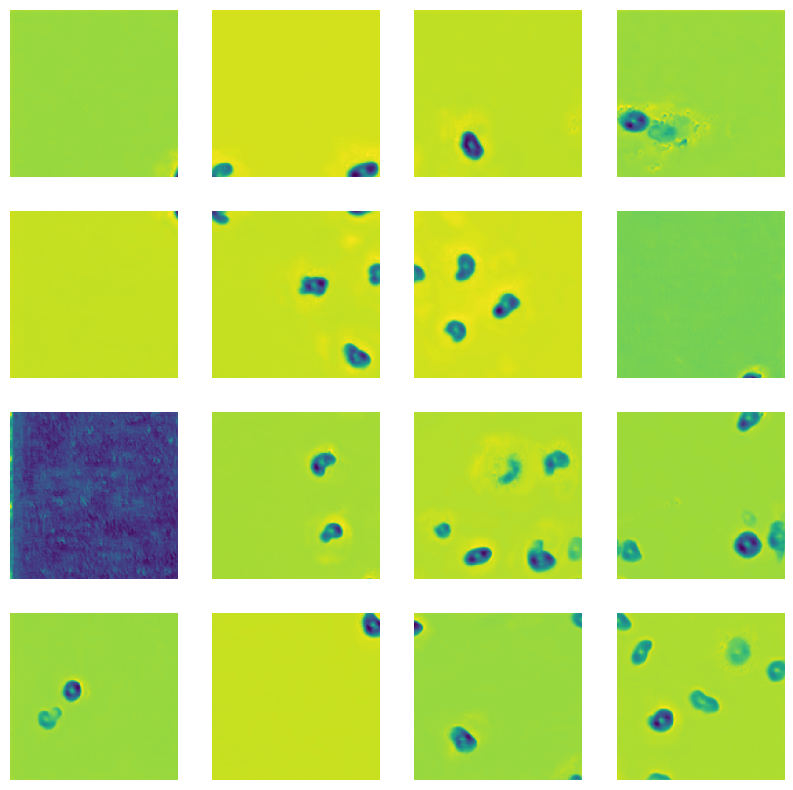

In [12]:
#TODO: add a function to take an image with 32 channels and return an array with the same number of channels but with each channel being a crop of the original image

print(images_torch_rotated_flipped[0].shape)
image = cp_upsamples_rotated_flipped[0]
print(image.shape)

print(image.shape[0]%256 == 0)
print(image.shape[0] == image.shape[1])

def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

crops = get_crops(image,256)       

#plots the crops as a grid
def plot_grid(crops):
    fig, axs = plt.subplots(4, 4, figsize=(10,10))
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(crops[i*4+j])
            axs[i,j].axis('off')
    plt.show()
print(len(crops))
plot_grid(crops)

In [22]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
#make a random torch array and input into the unet so that we can print the output shapes
x = torch.rand(1,1,256,256)
encFeatures, decFeatures, map = unet(x)
print(encFeatures[0].shape,decFeatures[0].shape,map.shape)

torch.Size([1, 32, 256, 256]) torch.Size([32, 256, 256]) torch.Size([1, 1, 256, 256])


In [74]:
train_dataset = ImageDataset(images_torch_rotated_flipped[:1], cp_downsamples_rotated_flipped[:1], cp_upsamples_rotated_flipped[:1], cp_outputs_rotated_flipped[:1])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ImageDataset(test_images, test_downsamples, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [20]:
import torchvision.transforms as T

class LF_one(torch.nn.Module):
    def __init__(self):
        super(LF_one, self).__init__()
    def forward(self, y_32_pred, y_32_true):
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())
        return y_32_loss
    
class LF_two(torch.nn.Module):
    def __init__(self):
        super(LF_two, self).__init__()
    def forward(self, y_3_pred, y_3_true):
        #transform = T.Resize(1024)
        #y_3_true = transform(y_3_true)

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        
        y_3_loss = F.binary_cross_entropy(y_3_pred, y_3_true.float())
    
        y_3_pred = y_3_pred.view(-1)
        y_3_true = y_3_true.view(-1)
        intersection = (y_3_pred * y_3_true).sum()
        total = (y_3_pred + y_3_true).sum()
        union = total - intersection 
        IoU_loss = 1 - (intersection + 1)/(union + 1)

        #print(y_3_loss, IoU_loss)
        return y_3_loss * 0.5 + IoU_loss * 0.5
    
class reg_con(torch.nn.Module):
    def __init__(self):
        super(reg_con, self).__init__()

    def forward(self, y_32_pred, y_32_true, y_3_true):
        #y_32_pred = F.sigmoid(y_32_pred)
        #y_32_true = F.sigmoid(y_32_true)

        #gt = F.sigmoid(y_3_true)
        #gt = torch.where(gt > 0.5, torch.ones_like(gt), torch.zeros_like(gt))

        #region_affinity_distillation = self.region_affinity_distillation(y_32_pred, y_32_true, gt)
        #transform = T.Resize(1024)
        #y_3_true = transform(y_3_true)
        y_32_pred_s = F.sigmoid(y_32_pred)
        y_32_true_s = F.sigmoid(y_32_true)
        y_3_loss = F.binary_cross_entropy(y_32_pred_s, y_32_true_s.float())

        c = self.contrast_loss(y_32_pred, y_32_true)
        return c * 0.5 + y_3_loss * 0.5
    
    def region_contrast(self, x, gt):
        """
        calculate region contrast value
        :param x: feature
        :param gt: mask
        :return: value
        """
        smooth = 1.0
        mask0 = (gt == 0)
        mask1 = (gt == 1)

        region0 = torch.sum(x * mask0, dim=(2, 3)) / torch.sum(mask0, dim=(2, 3))
        region1 = torch.sum(x * mask1, dim=(2, 3)) / (torch.sum(mask1, dim=(2, 3)) + smooth)
        return F.cosine_similarity(region0, region1, dim=1)
    
    def region_affinity_distillation(self, s, t, gt):
        """
        region affinity distillation KD loss
        :param s: student feature
        :param t: teacher feature
        :return: loss value
        """

        #
        gt = torch.unsqueeze(gt, 1)

        gt = F.interpolate(gt, s.size()[1:])

        #print(s.shape, t.shape, gt.shape)

        return (self.region_contrast(s, gt) - self.region_contrast(t, gt)).pow(2).mean()
    
    def contrast_loss(self, x, gt):
        #let's calculate the class difference

        #get the groundtruth mask
        gt_mask = gt
        gt_mask = gt_mask > 0.5

        #get the groundtruth cellprob
        gt_cp = gt
        gt_cp = F.sigmoid(gt_cp)

        #get all the gt_cp values that are 1
        gt_cp_0 = gt_cp[gt_mask == 0]
        gt_cp_1 = gt_cp[gt_mask == 1]

        #get the mean value of gt_cp_0
        gt_cp_0_mean = gt_cp_0.mean()
        gt_cp_1_mean = gt_cp_1.mean()

        pred = x
        pred = pred.unsqueeze(1)
        #print(pred.shape)
        #pred = F.interpolate(pred, (512,512))
        #print(pred.shape)
        #sigmoid the pred
        pred = F.sigmoid(pred)
        gt_mask = gt_mask.unsqueeze(1)
        pred_0 = pred[gt_mask == 0]
        pred_1 = pred[gt_mask == 1]
        pred_0_mean = pred_0.mean()
        pred_1_mean = pred_1.mean()

        #absolute difference between the contrasts
        return abs(gt_cp_0_mean - gt_cp_1_mean) - abs(pred_0_mean - pred_1_mean)

In [75]:
def trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler, epoch_num, step, device):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, donwsample_cp, upsample, cp_output in train_loader:
        #cast to float32
        image = image.float()
        donwsample_cp = donwsample_cp.float()
        upsample = upsample.float()
        cp_output = cp_output.float()
        (image, donwsample_cp, upsample, cp_output) = (image.to(device),donwsample_cp.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)
        
        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)
        
        if step == 1:
            transform = T.Resize(512)
            y_32_pred = transform(y_32_pred)
            loss = loss_fn(y_32_pred,  upsample) # calculate the loss of that prediction
            #loss = loss_fn(y_32_pred, upsample, cp_output)
        elif step == 2:
            if 4 == 5:
                kl_loss = torch.nn.KLDivLoss(reduction="mean")
                transform = T.Resize(1024)
                cp_output_t = transform(cp_output)

                y_3_pred = F.sigmoid(y_3_pred)
                #cp_output_t = F.sigmoid(cp_output_t)

                loss = kl_loss(y_3_pred.double().log(), cp_output_t.double().log())
            transform = T.Resize(512)
            y_3_pred = transform(y_3_pred)
            #print(y_3_pred.shape, cp_output.shape)
            loss = loss_fn(y_3_pred, cp_output)
            #transform = T.Resize(1024)
            #cp_output_t = transform(cp_output)
            #cp_output_t_bin = torch.where(cp_output_t > 0.5,
                                      #torch.ones_like(cp_output_t),
                                      #torch.zeros_like(cp_output_t))
            #loss = loss_fn(y_3_pred, cp_output_t)
            #transform = T.Resize(512)
            #y_3_pred = transform(y_3_pred)
            #loss = loss_fn(y_3_pred,  cp_output)

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if step == 2:
        iou_score = 0
        for image, donwsample_cp, upsample, cp_output in test_loader:
            image = image.float()
            donwsample_cp = donwsample_cp.float()
            upsample = upsample.float()
            cp_output = cp_output.float()
            (image, donwsample_cp, upsample, cp_output) = (image.to(device),donwsample_cp.to(device),upsample.to(device),cp_output.to(device))

            image = image.unsqueeze(1)
            y_16_pred, y_32_pred, y_3_pred = unet(image)
            
            y_32_pred = y_32_pred.squeeze(1)
            y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = F.sigmoid(y_3_pred)
            y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            transform = T.Resize(1024)
            cp_output = transform(cp_output)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)

            intersection = np.logical_and(cp_output, y_3_pred)
            union = np.logical_or(cp_output, y_3_pred)
            iou_score += np.sum(intersection) / np.sum(union)

        for image, donwsample_cp, upsample, cp_output in test_loader:
            
            (image, donwsample_cp, upsample, cp_output) = (image.to(device),donwsample_cp.to(device),upsample.to(device),cp_output.to(device))

            image = image.unsqueeze(1)
            y_16_pred, y_32_pred, y_3_pred = unet(image)
            y_32_pred = y_32_pred.squeeze(1)
            y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = F.sigmoid(y_3_pred)
            y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)
            
            if epoch_num % 10 == 0:
                plt.subplot(1,4,1)
                plt.imshow(y_3_pred)
                plt.subplot(1,4,2)
                plt.imshow(y_3_pred)
                plt.subplot(1,4,3)
                plt.imshow(cp_output)
                plt.subplot(1,4,4,)
                plt.imshow(cp_output)
                plt.show()
            
            break


        iou_score = iou_score/len(test_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        if step == 1:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
        elif step == 2:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)

    return unet

In [23]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('mps')

In [32]:
#TODO: add test loss here
step = 1
loss_fn = LF_one()
#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=1)

for epoch in range(300):
    unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=step,device='mps')

/Users/rehanzuberi/anaconda3/envs/newenv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch  0 Training loss:  0.0955074280500412 Time:  15.828920125961304
Epoch  1 Training loss:  0.09550401568412781 Time:  14.884006977081299
Epoch  2 Training loss:  0.09548962861299515 Time:  5.578941106796265
Epoch  3 Training loss:  0.09545838832855225 Time:  8.037684917449951
Epoch  4 Training loss:  0.09540624916553497 Time:  7.301707029342651
Epoch  5 Training loss:  0.0953306183218956 Time:  12.893114805221558
Epoch  6 Training loss:  0.09523001313209534 Time:  5.324915885925293
Epoch  7 Training loss:  0.09510385245084763 Time:  7.600287914276123
Epoch  8 Training loss:  0.09495222568511963 Time:  7.690990924835205
Epoch  9 Training loss:  0.09477785974740982 Time:  20.370302200317383
Epoch  10 Training loss:  0.0945834219455719 Time:  5.57893705368042
Epoch  11 Training loss:  0.0943695455789566 Time:  10.352138996124268
Epoch  12 Training loss:  0.09414343535900116 Time:  12.366520881652832
Epoch  13 Training loss:  0.09390130639076233 Time:  17.977813005447388
Epoch  14 Trai

KeyboardInterrupt: 

In [76]:
import gc
torch.cuda.empty_cache()
gc.collect()

966

In [ ]:
#Ok so I'm designing an experiment where we try to see if different manual seeds give a better result
#After having done the first training step, I give random weight initialisations to the head of the U-Net and then train it

#I first need to save the current model's weights as that is the base model we'll keep using to then train the head

In [34]:
torch.save(unet.state_dict(), "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/base_model")

In [68]:


unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('mps')
unet.load_state_dict(torch.load("/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/base_model"))
unet.encoder.requires_grad_ = False
unet.decoder.requires_grad_ = False
torch.manual_seed(3)
unet.head.weight = torch.nn.Parameter(torch.rand(unet.head.weight.shape))
print(unet.head.weight)

Parameter containing:
tensor([[[[0.0043]],

         [[0.1056]],

         [[0.2858]],

         [[0.0270]],

         [[0.4716]],

         [[0.0601]],

         [[0.7719]],

         [[0.7437]],

         [[0.5944]],

         [[0.8879]],

         [[0.4510]],

         [[0.7995]],

         [[0.1498]],

         [[0.4015]],

         [[0.0542]],

         [[0.4594]],

         [[0.1756]],

         [[0.9492]],

         [[0.8473]],

         [[0.8749]],

         [[0.6483]],

         [[0.2148]],

         [[0.9493]],

         [[0.0121]],

         [[0.1809]],

         [[0.1877]],

         [[0.2927]],

         [[0.5997]],

         [[0.1213]],

         [[0.1148]],

         [[0.2609]],

         [[0.8052]]]], requires_grad=True)


In [77]:
seeds = [0,1,2,3,4,5]

for seed in seeds:
    print('Seed:',seed)
    unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
    
    unet.load_state_dict(torch.load("/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/base_model"))
    
    unet.encoder.requires_grad_ = False
    unet.decoder.requires_grad_ = False

    torch.manual_seed(seed)
    unet.head.weight = torch.nn.Parameter(torch.rand(unet.head.weight.shape))

    unet = unet.to('mps')
    
    loss_fn = LF_two()
    optimiser = torch.optim.SGD(unet.parameters(), lr=0.01, momentum=0.1)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=0.01)
    for epoch in range(10):
        unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=2, device='mps')
    print('\n')

Seed: 0


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

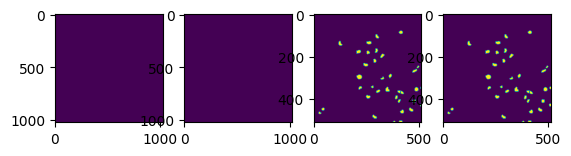

Epoch  0 Training loss:  0.7249435909892086 IoU score:  0.0 Time:  1.6885559558868408
Epoch  1 Training loss:  0.7236707068035262 IoU score:  0.0 Time:  1.4121246337890625
Epoch  2 Training loss:  0.7211624439643167 IoU score:  0.0 Time:  1.4044904708862305
Epoch  3 Training loss:  0.7174829330331423 IoU score:  0.0 Time:  1.4056639671325684
Epoch  4 Training loss:  0.7127156934217086 IoU score:  0.0 Time:  1.409203052520752
Epoch  5 Training loss:  0.7069554041550237 IoU score:  0.0 Time:  1.3934605121612549
Epoch  6 Training loss:  0.7003046259739286 IoU score:  0.0 Time:  1.3920817375183105
Epoch  7 Training loss:  0.6928693889337696 IoU score:  0.0 Time:  1.404625415802002
Epoch  8 Training loss:  0.6847529844030971 IoU score:  0.0 Time:  1.4115228652954102
Epoch  9 Training loss:  0.6760543648731179 IoU score:  0.0 Time:  1.4072484970092773


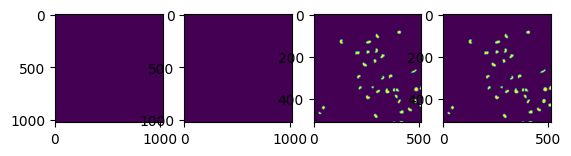

Epoch  10 Training loss:  0.6668681344150929 IoU score:  0.0 Time:  1.6140398979187012
Epoch  11 Training loss:  0.6572793069691963 IoU score:  0.0 Time:  1.4020400047302246
Epoch  12 Training loss:  0.6473608406122889 IoU score:  0.0 Time:  1.3835203647613525
Epoch  13 Training loss:  0.6371776484289893 IoU score:  0.0 Time:  1.381664752960205
Epoch  14 Training loss:  0.6267660406606387 IoU score:  0.0 Time:  1.38026762008667
Epoch  15 Training loss:  0.6161545700360072 IoU score:  0.0 Time:  1.3852767944335938
Epoch  16 Training loss:  0.6053353124428485 IoU score:  0.0011320577730876715 Time:  1.3871660232543945
Epoch  17 Training loss:  0.5942552562190464 IoU score:  0.023489245016055513 Time:  1.3895742893218994
Epoch  18 Training loss:  0.5828659975800952 IoU score:  0.22269005872252784 Time:  1.3718080520629883
Epoch  19 Training loss:  0.5712180828522049 IoU score:  0.33284473417940214 Time:  1.3778636455535889


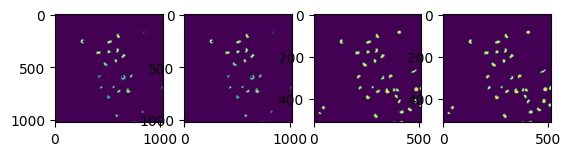

Epoch  20 Training loss:  0.5597641265299285 IoU score:  0.3895749045711357 Time:  1.5934772491455078
Epoch  21 Training loss:  0.5481553947088489 IoU score:  0.4357281586224482 Time:  1.358794927597046
Epoch  22 Training loss:  0.5359532136784908 IoU score:  0.47507014149193894 Time:  1.3869481086730957
Epoch  23 Training loss:  0.5232048542081779 IoU score:  0.5042013300381465 Time:  1.3637866973876953
Epoch  24 Training loss:  0.5100420639826544 IoU score:  0.5217997137031605 Time:  1.3622651100158691
Epoch  25 Training loss:  0.49651400363069775 IoU score:  0.5255798749822822 Time:  1.3773002624511719
Epoch  26 Training loss:  0.48258509121015697 IoU score:  0.5251893039442732 Time:  1.3873040676116943
Epoch  27 Training loss:  0.46813593306498563 IoU score:  0.5231647721590036 Time:  1.3596725463867188
Epoch  28 Training loss:  0.4529683811665431 IoU score:  0.5239647871982385 Time:  1.4001729488372803
Epoch  29 Training loss:  0.4368235463774315 IoU score:  0.5282305391366909 Tim

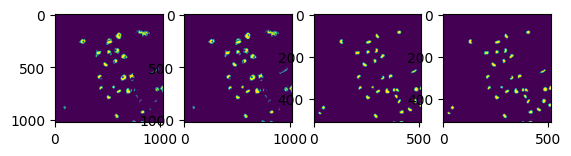

Epoch  30 Training loss:  0.419581934908965 IoU score:  0.5349578000997632 Time:  1.750260829925537
Epoch  31 Training loss:  0.40152554367351545 IoU score:  0.5393046347473681 Time:  1.4355604648590088
Epoch  32 Training loss:  0.3837659432099194 IoU score:  0.5384905715082443 Time:  1.4745776653289795
Epoch  33 Training loss:  0.3668381694628694 IoU score:  0.5394283445183248 Time:  1.4298627376556396
Epoch  34 Training loss:  0.34933479146595037 IoU score:  0.5408916596981594 Time:  1.451319694519043
Epoch  35 Training loss:  0.3334558266725697 IoU score:  0.5403165217183419 Time:  1.444913625717163
Epoch  36 Training loss:  0.31961016714732426 IoU score:  0.5429054006673009 Time:  1.479337215423584
Epoch  37 Training loss:  0.3071628684448746 IoU score:  0.5426928885844573 Time:  1.4872643947601318
Epoch  38 Training loss:  0.29761864719132375 IoU score:  0.5451076768538796 Time:  1.4781403541564941
Epoch  39 Training loss:  0.2894725483429763 IoU score:  0.5454477224717911 Time:  

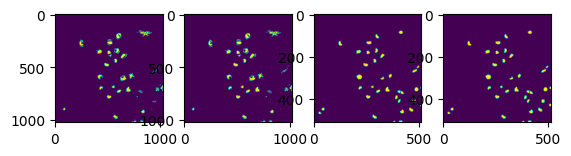

Epoch  40 Training loss:  0.2838380543051904 IoU score:  0.5470236555054552 Time:  1.6445298194885254
Epoch  41 Training loss:  0.27906306675837594 IoU score:  0.5481654215938337 Time:  1.375638723373413
Epoch  42 Training loss:  0.275778321060422 IoU score:  0.5497959437325786 Time:  1.3793878555297852
Epoch  43 Training loss:  0.27316959605262614 IoU score:  0.5508413892833893 Time:  1.3742494583129883
Epoch  44 Training loss:  0.2711499492924443 IoU score:  0.5509548657902217 Time:  1.3892278671264648
Epoch  45 Training loss:  0.26976090075492165 IoU score:  0.5520001640588492 Time:  1.3777060508728027
Epoch  46 Training loss:  0.26863280555203833 IoU score:  0.552290158955822 Time:  1.376934289932251
Epoch  47 Training loss:  0.26777994490190515 IoU score:  0.552863779049025 Time:  1.3819477558135986
Epoch  48 Training loss:  0.26716641239964767 IoU score:  0.552744857427871 Time:  1.3779103755950928
Epoch  49 Training loss:  0.26667191170250215 IoU score:  0.5531330351119106 Time:

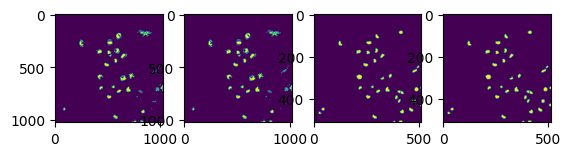

Epoch  50 Training loss:  0.26625409905733444 IoU score:  0.5533176521705963 Time:  1.5911364555358887
Epoch  51 Training loss:  0.26586668527721813 IoU score:  0.5533346289020064 Time:  1.3938207626342773
Epoch  52 Training loss:  0.26562555570954377 IoU score:  0.5543754397093869 Time:  1.3709757328033447
Epoch  53 Training loss:  0.265367451859418 IoU score:  0.5542816664800065 Time:  1.3684718608856201
Epoch  54 Training loss:  0.2651191166350585 IoU score:  0.5538087297325365 Time:  1.3780691623687744
Epoch  55 Training loss:  0.26490214638225806 IoU score:  0.5544260318998468 Time:  1.373115062713623
Epoch  56 Training loss:  0.26471004698720757 IoU score:  0.5544080613699646 Time:  1.3948876857757568
Epoch  57 Training loss:  0.26458437489010905 IoU score:  0.5539317596198534 Time:  1.3791627883911133
Epoch  58 Training loss:  0.2643587666244923 IoU score:  0.5542977627721564 Time:  1.3761374950408936
Epoch  59 Training loss:  0.26427574995006653 IoU score:  0.5542196164414179 T

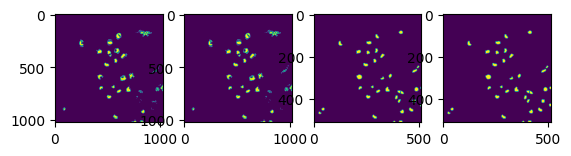

Epoch  60 Training loss:  0.2640973230086253 IoU score:  0.5540883398915631 Time:  1.5836153030395508
Epoch  61 Training loss:  0.2639194384235579 IoU score:  0.5542176533853254 Time:  1.384568214416504
Epoch  62 Training loss:  0.26379914078161926 IoU score:  0.5543968910106535 Time:  1.3720898628234863
Epoch  63 Training loss:  0.2636908785780571 IoU score:  0.5540024840711988 Time:  1.371469497680664
Epoch  64 Training loss:  0.263580809144197 IoU score:  0.5543695653735944 Time:  1.3784370422363281
Epoch  65 Training loss:  0.2634250652459555 IoU score:  0.5545307814395075 Time:  1.3700056076049805
Epoch  66 Training loss:  0.26330824656297025 IoU score:  0.5551453408742066 Time:  1.372689962387085
Epoch  67 Training loss:  0.26321297390516596 IoU score:  0.5544025819715461 Time:  1.3692715167999268
Epoch  68 Training loss:  0.2630771976744285 IoU score:  0.5549939693614115 Time:  1.3710458278656006
Epoch  69 Training loss:  0.2629749453960516 IoU score:  0.5545810477317178 Time:  

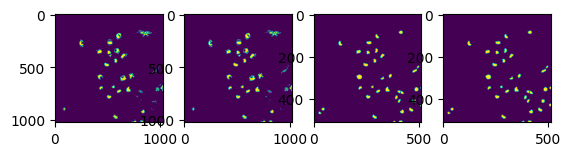

Epoch  70 Training loss:  0.2629094320026419 IoU score:  0.5550107686877823 Time:  1.5980093479156494
Epoch  71 Training loss:  0.2627794727489007 IoU score:  0.5555329190724692 Time:  1.3803725242614746
Epoch  72 Training loss:  0.26266845370217706 IoU score:  0.555780261954645 Time:  1.384242296218872
Epoch  73 Training loss:  0.2625911730164374 IoU score:  0.556092193448106 Time:  1.3873255252838135
Epoch  74 Training loss:  0.2624558762074241 IoU score:  0.5558891604263729 Time:  1.3878319263458252
Epoch  75 Training loss:  0.2623156817736302 IoU score:  0.5561878417725024 Time:  1.3925127983093262
Epoch  76 Training loss:  0.2621944053894808 IoU score:  0.5564287949387189 Time:  1.3801937103271484
Epoch  77 Training loss:  0.26207421400544845 IoU score:  0.5567167427363704 Time:  1.37607741355896
Epoch  78 Training loss:  0.26195142052100656 IoU score:  0.557089721838505 Time:  1.3783519268035889
Epoch  79 Training loss:  0.261897288532376 IoU score:  0.5567609861351468 Time:  1.3

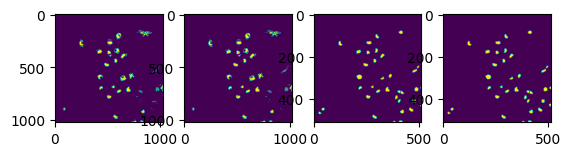

Epoch  80 Training loss:  0.2617751607252178 IoU score:  0.5567763876209237 Time:  1.6194846630096436
Epoch  81 Training loss:  0.2617179408294397 IoU score:  0.55729497318749 Time:  1.4172742366790771
Epoch  82 Training loss:  0.2616134371260677 IoU score:  0.5572145109690588 Time:  1.385411024093628
Epoch  83 Training loss:  0.2614338269751494 IoU score:  0.5571657351259627 Time:  1.3825781345367432
Epoch  84 Training loss:  0.26135796438382325 IoU score:  0.5577801096012946 Time:  1.3814561367034912
Epoch  85 Training loss:  0.2612963458568318 IoU score:  0.5579931610809385 Time:  1.4426367282867432
Epoch  86 Training loss:  0.26118386351271644 IoU score:  0.5580389708772406 Time:  1.4578022956848145
Epoch  87 Training loss:  0.26108487621916465 IoU score:  0.558239545830913 Time:  1.4013028144836426
Epoch  88 Training loss:  0.2610195376991985 IoU score:  0.5576560563079065 Time:  1.3737819194793701
Epoch  89 Training loss:  0.2610480255918965 IoU score:  0.5579974696364729 Time:  

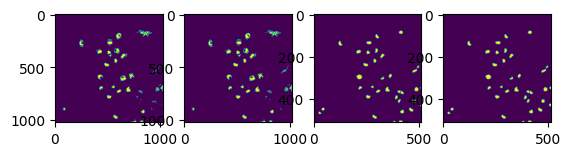

Epoch  90 Training loss:  0.26070777829243696 IoU score:  0.5581030564338318 Time:  1.6141688823699951
Epoch  91 Training loss:  0.26069187440056363 IoU score:  0.558624530895989 Time:  1.3974699974060059
Epoch  92 Training loss:  0.26055340002292693 IoU score:  0.5587419803752305 Time:  1.398850440979004
Epoch  93 Training loss:  0.26062134143942395 IoU score:  0.5587224416892012 Time:  1.4278700351715088
Epoch  94 Training loss:  0.2604117137579488 IoU score:  0.5593669131451001 Time:  1.3885536193847656
Epoch  95 Training loss:  0.26033956173094186 IoU score:  0.5602774885360959 Time:  1.3925766944885254
Epoch  96 Training loss:  0.26019892003809864 IoU score:  0.5598716539611541 Time:  1.3899962902069092
Epoch  97 Training loss:  0.25996798842679025 IoU score:  0.5591886821061864 Time:  1.389219045639038
Epoch  98 Training loss:  0.25982679410436194 IoU score:  0.5592722516380274 Time:  1.3897168636322021
Epoch  99 Training loss:  0.25982924475484803 IoU score:  0.5595191076072163 

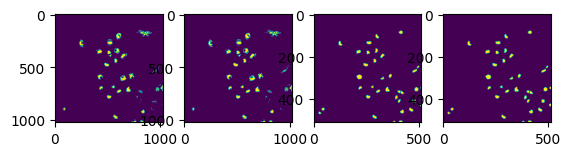

Epoch  100 Training loss:  0.25949505434742304 IoU score:  0.560034066128611 Time:  1.7492601871490479
Epoch  101 Training loss:  0.25949996392076413 IoU score:  0.5605508272085282 Time:  1.3920748233795166
Epoch  102 Training loss:  0.2595553703724508 IoU score:  0.5611699969666649 Time:  1.458620309829712
Epoch  103 Training loss:  0.25940022352991376 IoU score:  0.560652667928619 Time:  1.4596569538116455
Epoch  104 Training loss:  0.25936030672026744 IoU score:  0.5608056724830668 Time:  1.3863165378570557
Epoch  105 Training loss:  0.2590820867463829 IoU score:  0.5612418668046325 Time:  1.3717312812805176
Epoch  106 Training loss:  0.25891885211575716 IoU score:  0.5611182777246716 Time:  1.3862073421478271
Epoch  107 Training loss:  0.2586961968104811 IoU score:  0.560682463519917 Time:  1.3915073871612549
Epoch  108 Training loss:  0.2586268945874752 IoU score:  0.560117129956196 Time:  1.3788702487945557
Epoch  109 Training loss:  0.25874931552463387 IoU score:  0.561394643024

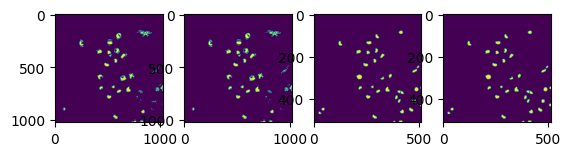

Epoch  110 Training loss:  0.25828876091809333 IoU score:  0.561542843725862 Time:  1.601257562637329
Epoch  111 Training loss:  0.2582087255905007 IoU score:  0.5611213001555247 Time:  1.3761389255523682
Epoch  112 Training loss:  0.25825774025826165 IoU score:  0.5621560729036637 Time:  1.3903050422668457
Epoch  113 Training loss:  0.2579399750193745 IoU score:  0.5621752112038109 Time:  1.3891286849975586
Epoch  114 Training loss:  0.2578108525995835 IoU score:  0.5619414951634372 Time:  1.3896758556365967
Epoch  115 Training loss:  0.25782381914427377 IoU score:  0.5625574179154382 Time:  1.3859169483184814
Epoch  116 Training loss:  0.2576219383523739 IoU score:  0.5624701350240235 Time:  1.3686411380767822
Epoch  117 Training loss:  0.2574973579868337 IoU score:  0.561727984437367 Time:  1.3799412250518799
Epoch  118 Training loss:  0.25772212992306753 IoU score:  0.5626784317748792 Time:  1.381944179534912
Epoch  119 Training loss:  0.257263051745335 IoU score:  0.56285083730163

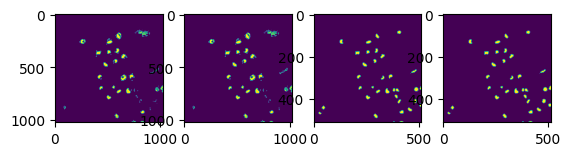

Epoch  120 Training loss:  0.25743710361849 IoU score:  0.56266475700765 Time:  1.6040472984313965
Epoch  121 Training loss:  0.2571274298742182 IoU score:  0.5631816870285091 Time:  1.3753554821014404
Epoch  122 Training loss:  0.256916934050357 IoU score:  0.5637644572750098 Time:  1.3821825981140137
Epoch  123 Training loss:  0.25683054342339307 IoU score:  0.5640009420297913 Time:  1.3759245872497559
Epoch  124 Training loss:  0.25682117880964905 IoU score:  0.5639558376931224 Time:  1.3734159469604492
Epoch  125 Training loss:  0.2566186106152357 IoU score:  0.5641861138560851 Time:  1.3799097537994385
Epoch  126 Training loss:  0.2566245123271481 IoU score:  0.5592963020533372 Time:  1.3725266456604004
Epoch  127 Training loss:  0.2589302578292989 IoU score:  0.5505794885009636 Time:  1.3727505207061768
Epoch  128 Training loss:  0.26141220440928625 IoU score:  0.5649739443080526 Time:  1.3810784816741943
Epoch  129 Training loss:  0.25673136718931033 IoU score:  0.56291493214476

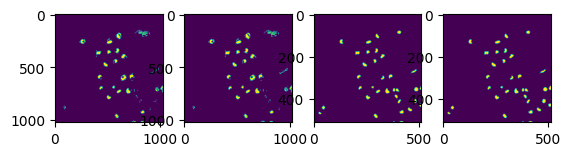

Epoch  130 Training loss:  0.2596886808938733 IoU score:  0.5649987731494083 Time:  1.5987622737884521
Epoch  131 Training loss:  0.2561934280426732 IoU score:  0.5651071856259358 Time:  1.3845195770263672
Epoch  132 Training loss:  0.25656181218258334 IoU score:  0.5571856350281346 Time:  1.376575231552124
Epoch  133 Training loss:  0.25932857084900207 IoU score:  0.550492902783587 Time:  1.3747732639312744
Epoch  134 Training loss:  0.2607087354119496 IoU score:  0.565840777254552 Time:  1.372429609298706
Epoch  135 Training loss:  0.2560847574530407 IoU score:  0.5635935340280764 Time:  1.3789000511169434
Epoch  136 Training loss:  0.25789427170898005 IoU score:  0.5644677080373559 Time:  1.3822312355041504
Epoch  137 Training loss:  0.25590109940358274 IoU score:  0.5664439379633089 Time:  1.3817899227142334
Epoch  138 Training loss:  0.25515868801913627 IoU score:  0.5603150218845616 Time:  1.3725814819335938
Epoch  139 Training loss:  0.25795896006208285 IoU score:  0.54487759453

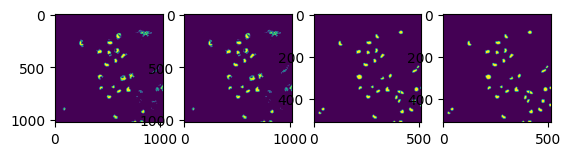

Epoch  140 Training loss:  0.26103162362094423 IoU score:  0.5639082937263622 Time:  1.5845227241516113
Epoch  141 Training loss:  0.26394019940771657 IoU score:  0.5671049575086426 Time:  1.368333339691162
Epoch  142 Training loss:  0.2712025783897148 IoU score:  0.3994333464651847 Time:  1.3747615814208984
Epoch  143 Training loss:  0.3586876422689974 IoU score:  0.3411921817910701 Time:  1.3835127353668213
Epoch  144 Training loss:  0.37043562283651826 IoU score:  0.4190968895623164 Time:  1.3811440467834473
Epoch  145 Training loss:  0.31487310340758523 IoU score:  0.4859369274091474 Time:  1.3697714805603027
Epoch  146 Training loss:  0.3231148316461125 IoU score:  0.4825758705395983 Time:  1.3821203708648682
Epoch  147 Training loss:  0.3023158691108715 IoU score:  0.47866917880824095 Time:  1.3780348300933838
Epoch  148 Training loss:  0.3059757749247006 IoU score:  0.45987730697437834 Time:  1.3840022087097168
Epoch  149 Training loss:  0.3098321643811289 IoU score:  0.48077056

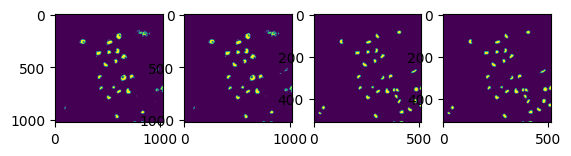

Epoch  150 Training loss:  0.29524378335025425 IoU score:  0.5086083047750776 Time:  1.6014602184295654
Epoch  151 Training loss:  0.2939641959239703 IoU score:  0.5026509512232706 Time:  1.3683502674102783
Epoch  152 Training loss:  0.28806787269691886 IoU score:  0.4999178615518607 Time:  1.3730847835540771
Epoch  153 Training loss:  0.2841806296293157 IoU score:  0.4968686540922056 Time:  1.378464698791504
Epoch  154 Training loss:  0.2813460182164996 IoU score:  0.5233364717845641 Time:  1.374664068222046
Epoch  155 Training loss:  0.27658399411601664 IoU score:  0.5263837118119961 Time:  1.3750114440917969
Epoch  156 Training loss:  0.27250263050233925 IoU score:  0.5170767129357232 Time:  1.3678498268127441
Epoch  157 Training loss:  0.2726069245658508 IoU score:  0.5314950171372002 Time:  1.3789875507354736
Epoch  158 Training loss:  0.27070838884919557 IoU score:  0.5331830026548516 Time:  1.3776330947875977
Epoch  159 Training loss:  0.2690948852042838 IoU score:  0.5311159809

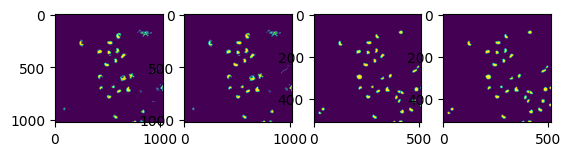

Epoch  160 Training loss:  0.2681081087101853 IoU score:  0.5310216077899699 Time:  1.5897862911224365
Epoch  161 Training loss:  0.2679533673822959 IoU score:  0.5313681241166726 Time:  1.3880484104156494
Epoch  162 Training loss:  0.26761124050159685 IoU score:  0.534921819936033 Time:  1.3744301795959473
Epoch  163 Training loss:  0.26678824136043766 IoU score:  0.5355704433384365 Time:  1.3835926055908203
Epoch  164 Training loss:  0.2661517125935562 IoU score:  0.5379249999819201 Time:  1.3724746704101562
Epoch  165 Training loss:  0.26533527593599393 IoU score:  0.5387816318933933 Time:  1.3818392753601074
Epoch  166 Training loss:  0.26473879213187834 IoU score:  0.5398561436546256 Time:  1.3742172718048096
Epoch  167 Training loss:  0.264294878176336 IoU score:  0.540214744167099 Time:  1.3774769306182861
Epoch  168 Training loss:  0.26391294468046134 IoU score:  0.541123905524111 Time:  1.3675220012664795
Epoch  169 Training loss:  0.26344155763874544 IoU score:  0.54328854920

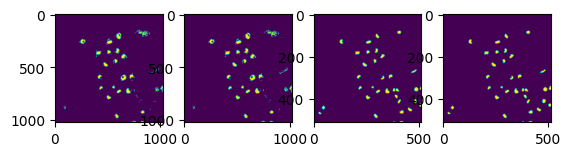

Epoch  170 Training loss:  0.2630550210704388 IoU score:  0.5425747250545687 Time:  1.594001054763794
Epoch  171 Training loss:  0.2626166980755738 IoU score:  0.5447932979193106 Time:  1.3733904361724854
Epoch  172 Training loss:  0.26219452890140993 IoU score:  0.5449645973537776 Time:  1.3835790157318115
Epoch  173 Training loss:  0.261787158192191 IoU score:  0.5471231302190658 Time:  1.3792338371276855
Epoch  174 Training loss:  0.2613818875557572 IoU score:  0.5469352887207668 Time:  1.3866405487060547
Epoch  175 Training loss:  0.2609820506776609 IoU score:  0.5482415978437245 Time:  1.3880257606506348
Epoch  176 Training loss:  0.26078674562653475 IoU score:  0.5475705607646844 Time:  1.3791577816009521
Epoch  177 Training loss:  0.2604209743510155 IoU score:  0.5485262295783144 Time:  1.3832783699035645
Epoch  178 Training loss:  0.26004003376796037 IoU score:  0.550156438122078 Time:  1.3760480880737305
Epoch  179 Training loss:  0.25943020937407746 IoU score:  0.552098167831

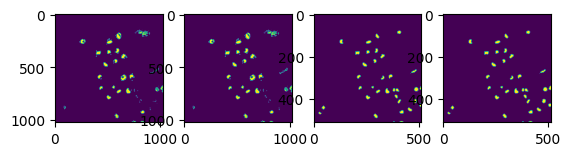

Epoch  180 Training loss:  0.2590157373187979 IoU score:  0.5536353863342962 Time:  1.597351312637329
Epoch  181 Training loss:  0.25883726711205 IoU score:  0.5554810972257075 Time:  1.381302833557129
Epoch  182 Training loss:  0.2584950386640956 IoU score:  0.556939840218124 Time:  1.3824608325958252
Epoch  183 Training loss:  0.2581653906392276 IoU score:  0.5575146750319859 Time:  1.3788747787475586
Epoch  184 Training loss:  0.25787343710794575 IoU score:  0.5583463144188523 Time:  1.3761236667633057
Epoch  185 Training loss:  0.25775166755453527 IoU score:  0.5578498213830607 Time:  1.378361701965332
Epoch  186 Training loss:  0.2575286630808964 IoU score:  0.5590466599857644 Time:  1.3876891136169434
Epoch  187 Training loss:  0.257172690772812 IoU score:  0.5600322769776686 Time:  1.3868207931518555
Epoch  188 Training loss:  0.2568386883946352 IoU score:  0.5614972841107648 Time:  1.3785908222198486
Epoch  189 Training loss:  0.2568545832337229 IoU score:  0.5627745292552405 T

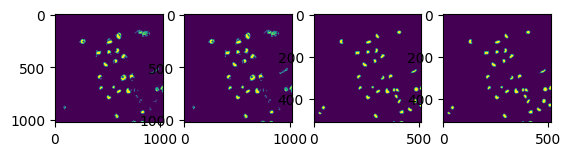

Epoch  190 Training loss:  0.25661350480892803 IoU score:  0.5636762848319037 Time:  1.6181094646453857
Epoch  191 Training loss:  0.2562096480872534 IoU score:  0.5634553294058237 Time:  1.3897016048431396
Epoch  192 Training loss:  0.2561247336549089 IoU score:  0.5629869876664959 Time:  1.39072585105896
Epoch  193 Training loss:  0.2559547624807348 IoU score:  0.5632527055262048 Time:  1.3749871253967285
Epoch  194 Training loss:  0.255698053120503 IoU score:  0.5649173116407495 Time:  1.3725464344024658
Epoch  195 Training loss:  0.25524378248332913 IoU score:  0.5649434840072467 Time:  1.3856475353240967
Epoch  196 Training loss:  0.2551887735865982 IoU score:  0.5671057452030475 Time:  1.384655237197876
Epoch  197 Training loss:  0.2549516480975851 IoU score:  0.5662547839345802 Time:  1.4163718223571777
Epoch  198 Training loss:  0.2547544954189638 IoU score:  0.5665469587893912 Time:  1.378218650817871
Epoch  199 Training loss:  0.2543738422321149 IoU score:  0.567282284299178 

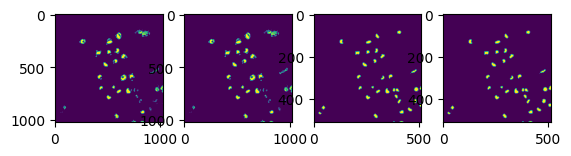

Epoch  200 Training loss:  0.254233776794053 IoU score:  0.5662568909310104 Time:  1.6255700588226318
Epoch  201 Training loss:  0.254063446696232 IoU score:  0.5690780227978679 Time:  1.5218150615692139
Epoch  202 Training loss:  0.25404459530562984 IoU score:  0.5684513565223628 Time:  1.3799335956573486
Epoch  203 Training loss:  0.2537244390269474 IoU score:  0.5680672072033808 Time:  1.3877875804901123
Epoch  204 Training loss:  0.25332968311213344 IoU score:  0.5699406572664463 Time:  1.372119426727295
Epoch  205 Training loss:  0.25325732472709434 IoU score:  0.5694611782273769 Time:  1.382483959197998
Epoch  206 Training loss:  0.25290199505568545 IoU score:  0.5691148256038312 Time:  1.3938837051391602
Epoch  207 Training loss:  0.25250056096330475 IoU score:  0.5714583951977934 Time:  1.3932533264160156
Epoch  208 Training loss:  0.2525397363697768 IoU score:  0.5714930766506212 Time:  1.4017236232757568
Epoch  209 Training loss:  0.2521432381017677 IoU score:  0.571169305884

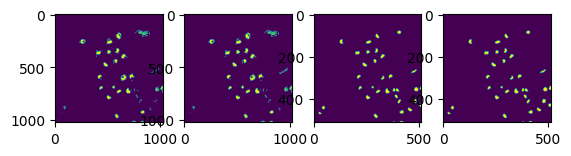

Epoch  210 Training loss:  0.2517313805196763 IoU score:  0.5737371043056506 Time:  1.6149358749389648
Epoch  211 Training loss:  0.25166159748101047 IoU score:  0.5719633908018055 Time:  1.387681245803833
Epoch  212 Training loss:  0.2512663006281689 IoU score:  0.5728143957459468 Time:  1.3775715827941895
Epoch  213 Training loss:  0.250904617398459 IoU score:  0.5735946588646295 Time:  1.394838809967041
Epoch  214 Training loss:  0.2507355884923516 IoU score:  0.5751848345146224 Time:  1.387760877609253
Epoch  215 Training loss:  0.2504288517755694 IoU score:  0.5751125047850749 Time:  1.3912510871887207
Epoch  216 Training loss:  0.25012631043997424 IoU score:  0.575659621418858 Time:  1.3746542930603027
Epoch  217 Training loss:  0.24992890215277547 IoU score:  0.575131466559641 Time:  1.3845124244689941
Epoch  218 Training loss:  0.24962181371749861 IoU score:  0.5765249129096137 Time:  1.369741678237915
Epoch  219 Training loss:  0.24932231803968147 IoU score:  0.576204370375847

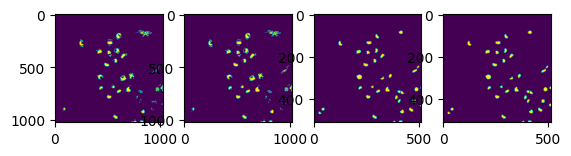

Epoch  220 Training loss:  0.24909817550393057 IoU score:  0.577882713796892 Time:  1.587555170059204
Epoch  221 Training loss:  0.24880526639118167 IoU score:  0.5780100593548304 Time:  1.3854186534881592
Epoch  222 Training loss:  0.24851032198241524 IoU score:  0.5778190156845038 Time:  1.397362470626831
Epoch  223 Training loss:  0.24827373409613454 IoU score:  0.5788435195928574 Time:  1.3784773349761963
Epoch  224 Training loss:  0.24798239863530153 IoU score:  0.5791796099127571 Time:  1.3878452777862549
Epoch  225 Training loss:  0.24789837893075173 IoU score:  0.5765719887442327 Time:  1.380241870880127
Epoch  226 Training loss:  0.24987038630548378 IoU score:  0.559761582360814 Time:  1.3833587169647217
Epoch  227 Training loss:  0.25492564991926003 IoU score:  0.5691167607350107 Time:  1.3887999057769775
Epoch  228 Training loss:  0.25059727751563377 IoU score:  0.579898797083199 Time:  1.3707385063171387
Epoch  229 Training loss:  0.2474628221662814 IoU score:  0.5813662762

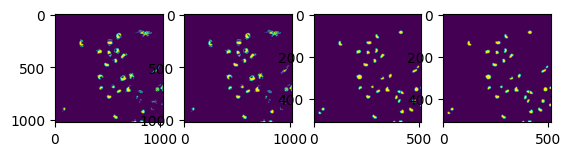

Epoch  230 Training loss:  0.2468261902205277 IoU score:  0.5806409770408855 Time:  1.6229808330535889
Epoch  231 Training loss:  0.24672305938928332 IoU score:  0.5762256246631541 Time:  1.3878161907196045
Epoch  232 Training loss:  0.24954737672711896 IoU score:  0.5457734842940982 Time:  1.4130144119262695
Epoch  233 Training loss:  0.25627584289554306 IoU score:  0.583047932021338 Time:  1.3911454677581787
Epoch  234 Training loss:  0.24974860127980592 IoU score:  0.5772905474556027 Time:  1.3814539909362793
Epoch  235 Training loss:  0.24967711829029948 IoU score:  0.5825851126593586 Time:  1.3874104022979736
Epoch  236 Training loss:  0.24565220143634914 IoU score:  0.5802166097959989 Time:  1.4016225337982178
Epoch  237 Training loss:  0.24650616370883638 IoU score:  0.5663013803524074 Time:  1.3806712627410889
Epoch  238 Training loss:  0.25212830770903905 IoU score:  0.558124479490464 Time:  1.369164228439331
Epoch  239 Training loss:  0.25179234014551755 IoU score:  0.5762368

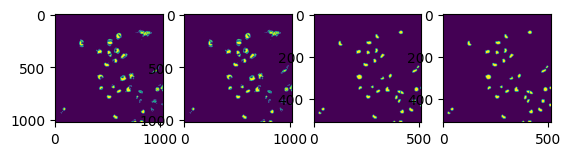

Epoch  240 Training loss:  0.2595920615313472 IoU score:  0.5793718053855568 Time:  1.6188733577728271
Epoch  241 Training loss:  0.2893466295516438 IoU score:  0.3451618681847835 Time:  1.3734729290008545
Epoch  242 Training loss:  0.3823003587122458 IoU score:  0.36234146328771016 Time:  1.3783462047576904
Epoch  243 Training loss:  0.3595775976767195 IoU score:  0.09178413048935041 Time:  1.3766138553619385
Epoch  244 Training loss:  0.42055177029232577 IoU score:  0.2565526789501994 Time:  1.3729891777038574
Epoch  245 Training loss:  0.49067015110074247 IoU score:  0.2573001905190109 Time:  1.3677332401275635
Epoch  246 Training loss:  0.4499123140961566 IoU score:  0.40562494564646356 Time:  1.3722922801971436
Epoch  247 Training loss:  0.3518633325162989 IoU score:  0.012297033714122104 Time:  1.3680918216705322
Epoch  248 Training loss:  0.3848413732160004 IoU score:  0.47338609243271207 Time:  1.3772356510162354
Epoch  249 Training loss:  0.32775912579623323 IoU score:  0.4436

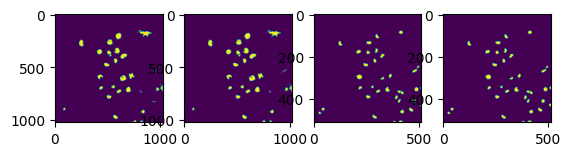

Epoch  250 Training loss:  0.3148547032668223 IoU score:  0.46203332054427665 Time:  1.6042542457580566
Epoch  251 Training loss:  0.2992226379490142 IoU score:  0.48410683642410324 Time:  1.3650884628295898
Epoch  252 Training loss:  0.2992735355317785 IoU score:  0.4672847566504661 Time:  1.3788378238677979
Epoch  253 Training loss:  0.2952739605312239 IoU score:  0.4966703891352452 Time:  1.3888044357299805
Epoch  254 Training loss:  0.2935538317318872 IoU score:  0.4665223500325704 Time:  1.3862676620483398
Epoch  255 Training loss:  0.30245431212922724 IoU score:  0.46307637589909134 Time:  1.395766258239746
Epoch  256 Training loss:  0.29030209810332747 IoU score:  0.4591530881318147 Time:  1.409317970275879
Epoch  257 Training loss:  0.3047659475208351 IoU score:  0.43268502747652626 Time:  1.3771140575408936
Epoch  258 Training loss:  0.32002592373856176 IoU score:  0.46000618417377637 Time:  1.401778221130371
Epoch  259 Training loss:  0.29212500714627165 IoU score:  0.5017300

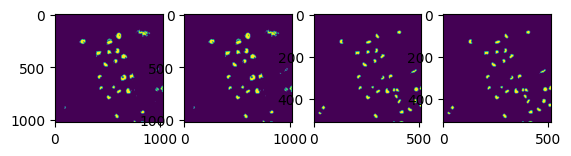

Epoch  260 Training loss:  0.300685667533622 IoU score:  0.5065233633036478 Time:  1.5995051860809326
Epoch  261 Training loss:  0.2888773917367551 IoU score:  0.4630906248389751 Time:  1.3811721801757812
Epoch  262 Training loss:  0.29630046366590096 IoU score:  0.48037342211459466 Time:  1.3666481971740723
Epoch  263 Training loss:  0.2871404457941747 IoU score:  0.5168481876201848 Time:  1.3901524543762207
Epoch  264 Training loss:  0.28864354697924444 IoU score:  0.5164116861095986 Time:  1.3928170204162598
Epoch  265 Training loss:  0.2829967971395686 IoU score:  0.49445301747573744 Time:  1.3882007598876953
Epoch  266 Training loss:  0.28412643990922687 IoU score:  0.5056050023073806 Time:  1.400359869003296
Epoch  267 Training loss:  0.2795296628744821 IoU score:  0.5101030916359623 Time:  1.3727896213531494
Epoch  268 Training loss:  0.279319745642696 IoU score:  0.5099395648789384 Time:  1.3933935165405273
Epoch  269 Training loss:  0.27799141489814516 IoU score:  0.5192153896

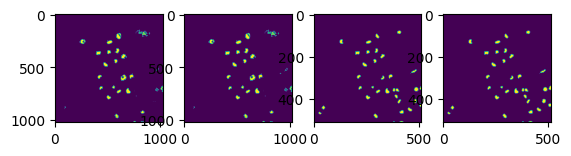

Epoch  270 Training loss:  0.2757090644119484 IoU score:  0.5233804723917679 Time:  1.595012903213501
Epoch  271 Training loss:  0.27417785569997866 IoU score:  0.5205282929839092 Time:  1.3632946014404297
Epoch  272 Training loss:  0.2735768240895487 IoU score:  0.524038381658327 Time:  1.3702890872955322
Epoch  273 Training loss:  0.27281671265436025 IoU score:  0.5249540230183534 Time:  1.3892176151275635
Epoch  274 Training loss:  0.2719346010848973 IoU score:  0.5253191532960391 Time:  1.397129774093628
Epoch  275 Training loss:  0.2714335495700438 IoU score:  0.5279324780563918 Time:  1.380908727645874
Epoch  276 Training loss:  0.2707798831412981 IoU score:  0.5290090636092509 Time:  1.3792757987976074
Epoch  277 Training loss:  0.27029483822402367 IoU score:  0.5308737200389796 Time:  1.3797848224639893
Epoch  278 Training loss:  0.26953878739217846 IoU score:  0.5329435944287613 Time:  1.3915293216705322
Epoch  279 Training loss:  0.26920530601777276 IoU score:  0.533432474685

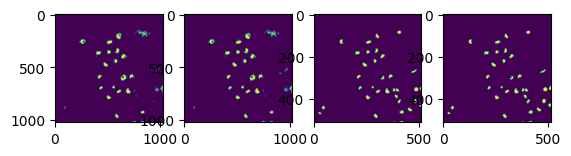

Epoch  280 Training loss:  0.26857016664548533 IoU score:  0.5360381765830818 Time:  1.615894079208374
Epoch  281 Training loss:  0.26820397757165343 IoU score:  0.5363819939383627 Time:  1.3911404609680176
Epoch  282 Training loss:  0.26774250476349937 IoU score:  0.5375879877579677 Time:  1.3641109466552734
Epoch  283 Training loss:  0.26746542291139863 IoU score:  0.5383802795010263 Time:  1.3611392974853516
Epoch  284 Training loss:  0.26714783552506727 IoU score:  0.5389667504384874 Time:  1.373035192489624
Epoch  285 Training loss:  0.2668873651176341 IoU score:  0.5401243654125536 Time:  1.3736648559570312
Epoch  286 Training loss:  0.266513514163466 IoU score:  0.5410393911776543 Time:  1.3788607120513916
Epoch  287 Training loss:  0.2662223337464209 IoU score:  0.5418733759061116 Time:  1.3697056770324707
Epoch  288 Training loss:  0.26582641548762564 IoU score:  0.5418950334911375 Time:  1.3736765384674072
Epoch  289 Training loss:  0.2655593776088902 IoU score:  0.5420395913

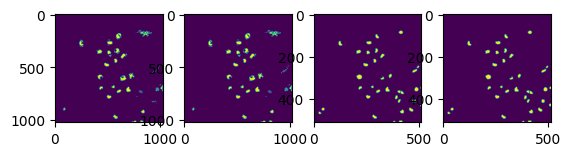

Epoch  290 Training loss:  0.265498041556227 IoU score:  0.5413827994317799 Time:  1.6222937107086182
Epoch  291 Training loss:  0.26519886582784746 IoU score:  0.5411191407110947 Time:  1.3840751647949219
Epoch  292 Training loss:  0.2649581180705306 IoU score:  0.5431886464640867 Time:  1.3709282875061035
Epoch  293 Training loss:  0.2644913483556577 IoU score:  0.544261818130588 Time:  1.3657171726226807
Epoch  294 Training loss:  0.2641461560442451 IoU score:  0.545218031095926 Time:  1.3705644607543945
Epoch  295 Training loss:  0.263968960134367 IoU score:  0.5465506474473537 Time:  1.3722496032714844
Epoch  296 Training loss:  0.26364637109851113 IoU score:  0.5473214266283017 Time:  1.3747494220733643
Epoch  297 Training loss:  0.26329718266205115 IoU score:  0.5477309247503193 Time:  1.365509271621704
Epoch  298 Training loss:  0.26289151110138265 IoU score:  0.5477514310297413 Time:  1.3648455142974854
Epoch  299 Training loss:  0.26282754907303635 IoU score:  0.5463961270050

In [133]:
step = 2
loss_fn = LF_two()

#loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.01, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=0.01)

for epoch in range(300):
    unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=step)

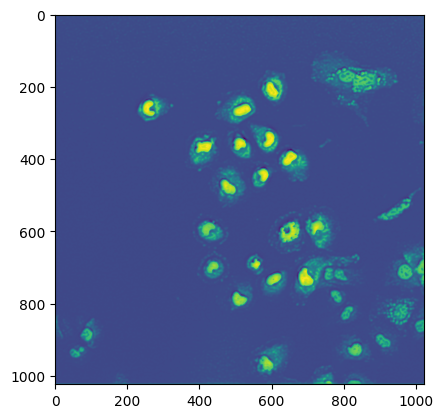

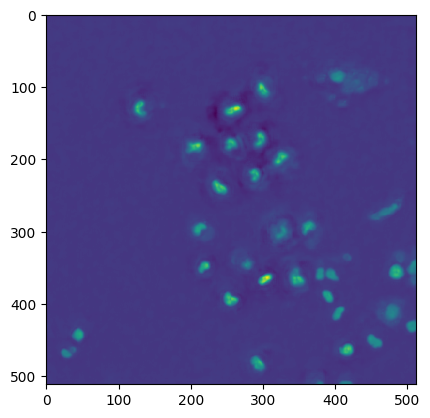

In [102]:
#make a prediction and let's apply modifications

def make_pred(unet, image):
    image = image.unsqueeze(0).unsqueeze(0)
    image = image.to('cuda:0')
    y_16_pred, y_32_pred, y_3_pred = unet(image)
    y_32_pred = y_32_pred.squeeze(0)
    y_3_pred = y_3_pred.squeeze(0)
    y_3_pred = y_3_pred.cpu().detach().numpy()[0]
    return y_3_pred

image = test_images[0]
y_3_pred = make_pred(unet, image)

plt.imshow(y_3_pred)
plt.show()
plt.imshow(test_cellprob[0])
plt.show()

In [112]:
print(1/(1+np.exp(-y_3_pred)))

[[3.7452042e-02 7.0178602e-03 4.0167989e-03 ... 3.3095255e-03
  5.1450953e-03 2.6370173e-02]
 [7.6496913e-03 5.9263961e-04 2.6556733e-04 ... 2.0178474e-04
  3.9448857e-04 5.6556645e-03]
 [5.8174767e-03 4.1126096e-04 1.8975578e-04 ... 1.5369982e-04
  2.8266993e-04 4.5582186e-03]
 ...
 [4.9159769e-03 2.7325284e-04 9.0897774e-05 ... 8.7848290e-05
  2.0780123e-04 4.1271639e-03]
 [8.2258247e-03 6.8107474e-04 2.7683802e-04 ... 2.6732427e-04
  5.4451864e-04 7.4583027e-03]
 [3.7217747e-02 8.7196529e-03 5.2912631e-03 ... 5.2062236e-03
  8.0172373e-03 4.1619029e-02]]


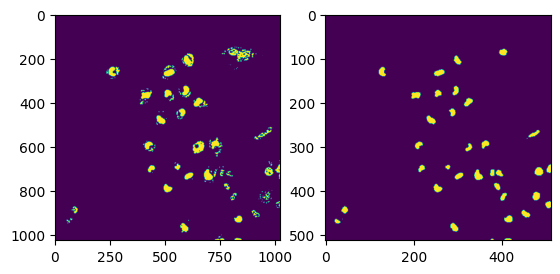

In [125]:
pred = y_3_pred
#put pred through a sigmoid function
pred = 1/(1+np.exp(-pred))
pred = pred > 0.5

gt = test_cellprob[0]
gt = gt > 0.5

plt.subplot(1,2,1)
plt.imshow(pred)
plt.subplot(1,2,2)
plt.imshow(gt)
plt.show()

In [241]:
#let's calculate the class difference

#get the groundtruth mask
gt_mask = test_cellprob[0]
gt_mask = gt_mask > 0.5

#get the groundtruth cellprob
gt_cp = test_cellprob[0]
gt_cp = F.sigmoid(gt_cp)

#get all the gt_cp values that are 1
gt_cp_0 = gt_cp[gt_mask == 0]
gt_cp_1 = gt_cp[gt_mask == 1]

#get the mean value of gt_cp_0
gt_cp_0_mean = gt_cp_0.mean()
gt_cp_1_mean = gt_cp_1.mean()

pred = y_3_pred
pred = np.resize(pred, (512,512))
#sigmoid the pred
pred = F.sigmoid(torch.from_numpy(pred))
pred_0 = pred[gt_mask == 0]
pred_1 = pred[gt_mask == 1]
pred_0_mean = pred_0.mean()
pred_1_mean = pred_1.mean()

#absolute difference between the contrasts
print(abs(gt_cp_0_mean - gt_cp_1_mean) - abs(pred_0_mean - pred_1_mean))

tensor(0.0031, dtype=torch.float64)
tensor(0.9575, dtype=torch.float64)
tensor(-0.9543, dtype=torch.float64)
tensor(0.4707)
tensor(0.4707)
tensor(-4.6015e-05)
tensor(0.9543, dtype=torch.float64)


c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [150]:
print(gt.unsqueeze(0).shape)
mask0 = gt[:, 0].unsqueeze(1)
mask1 = gt[:, 1].unsqueeze(1)

torch.Size([1, 512, 512])


In [155]:
print(np.unique(mask0))
print(np.unique(mask1))


[False]
[False]


In [ ]:
print(test_cellprob[0])

tensor([[-8.2197, -8.0311, -7.9962,  ..., -7.6628, -7.7984, -7.9332],
        [-8.1718, -8.4967, -8.1357,  ..., -7.6183, -7.8410, -8.0483],
        [-8.1877, -8.8362, -8.4895,  ..., -7.8520, -8.0727, -8.2621],
        ...,
        [-8.1536, -8.7004, -7.9286,  ..., -8.0617, -8.0611, -8.4182],
        [-8.1920, -8.6453, -7.8699,  ..., -7.9053, -8.0869, -8.2721],
        [-7.9803, -8.5260, -8.5515,  ..., -8.3653, -8.5924, -8.5442]],
       dtype=torch.float64)
